# Big Data Analytics Project: Medical Appointments No Shows

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Table of Contents

1. [Decision Tree: interpretation and explanation](#tree) 
2. [Decision Tree without *WaitingDays*](#tree_no_days)
3. [GaussianNB: interpretation and explanation](#gaussian)
4. [Conclusions](#conclusions)

First of all, we install the SHAP library.

In [ ]:
!pip install shap

     |████████████████████████████████| 564 kB 4.1 MB/s 


Then we import some useful libraries.

In [ ]:
%matplotlib inline
import shap
import numpy as np
import pandas as pd 
import scipy as sp
import sklearn as sk
import matplotlib.pylab as plt
import seaborn as sns
import pickle
from sklearn import tree
from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import graphviz
import warnings
warnings.filterwarnings("ignore")

In [ ]:
sns.set_style('darkgrid')        # darkgrid, white grid, dark, white and ticks
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('legend', fontsize=13)    # legend fontsize

We load the train and the test set (the ones with only the selected features), that were created in the part 2 notebook.

In [ ]:
X_train = pd.read_csv("/content/drive/MyDrive/BigData/X_train.csv")
X_test = pd.read_csv("/content/drive/MyDrive/BigData/X_test.csv")
y_test = pd.read_csv("/content/drive/MyDrive/BigData/y_test.csv")
y_train = pd.read_csv("/content/drive/MyDrive/BigData/y_train.csv")

<a id='tree'></a>
# Decision Tree: interpretation and explanation

We load the decision tree, since in the previous analisys it was selected as the best model.

In [ ]:
decision_tree_file = open('/content/drive/MyDrive/BigData/DecisionTreeClassifier_sf','rb')
decision_tree = pickle.load(decision_tree_file)
decision_tree_file.close()

First of all, we plot the feature importances computed by the decision tree classifier.

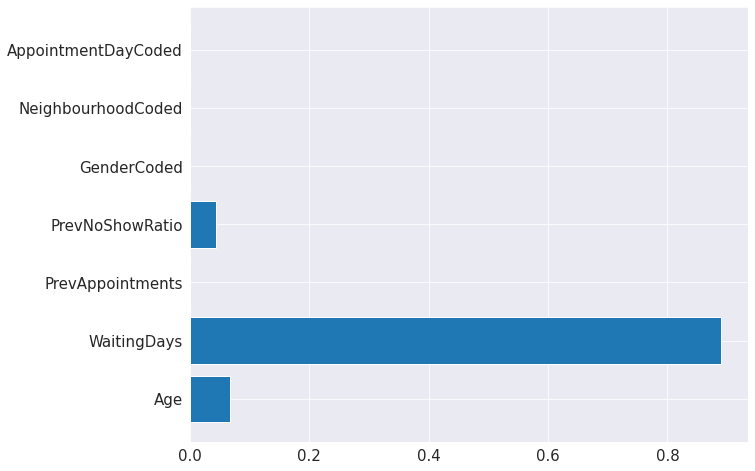

In [ ]:
plt.figure(figsize=(10, 8))
plt.barh([x for x in range(len(decision_tree.feature_importances_))], decision_tree.feature_importances_, tick_label=X_train.columns)
plt.rc('font', size=10)
plt.show()

We note that *WaitingDays* is by far the most important feature, followed by *Age* and *PrevNoShowRatio*. The other features seem to have no importance.

Now we draw the decision tree to inspect it visually.

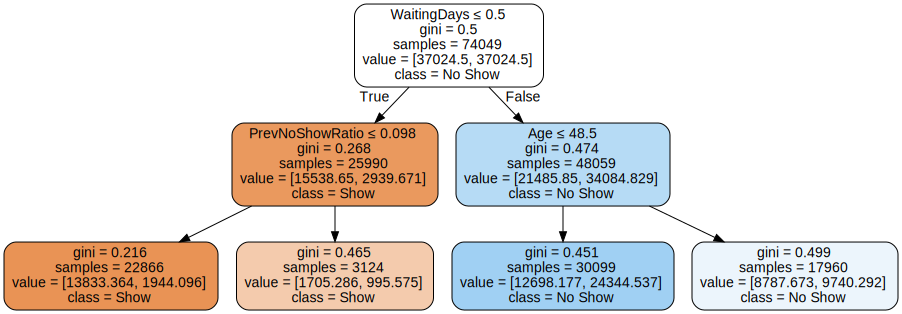

In [ ]:
dot_data = tree.export_graphviz(decision_tree, out_file=None, feature_names=X_train.columns, class_names=["Show", "No Show"], filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data, format="png") 
graph

We note that the decision tree is very simple. The only tested attributes are *WaitingDays*, *Age* and *PrevNoShowRatio*. However, we see that the decision tree can be reduced to only one condition: **if *WaitingDays* is 0 then the record is classified as *Show* otherwise it is classified as *No Show***.

Now we visualize the variable importance plot and the predictive power of each variable.

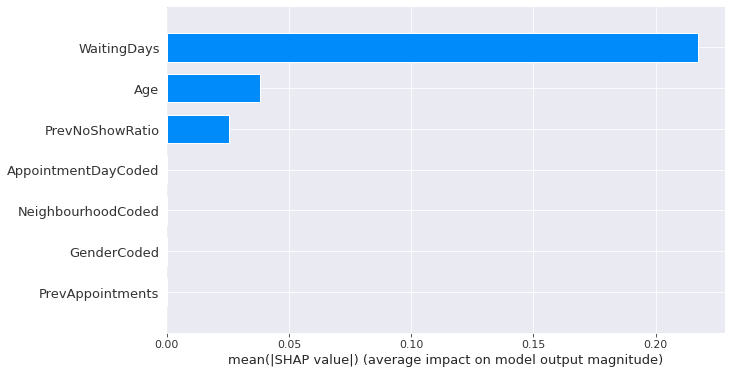

In [ ]:
explainer_dt = shap.TreeExplainer(decision_tree, data=X_train)
shap_values_dt = explainer_dt.shap_values(X_test)
shap.summary_plot(shap_values_dt[1], X_test, plot_type="bar", plot_size=(10, 6))

The plot confirms what was previously observed: the only variables that have some importance are *WaitingDays*, *Age* and *PrevNoShowRatio* and *WaitingDays* is by far the more important one.

Since the decision tree obtained is a very trivial classifier, we do not need to futher investigate it. The local explanation for any given record can be obtained by simply applying the rule: 

```
if WaitingDays = 0 then Show
else No_show
```



<a id='tree_no_days'></a>
# Decision Tree without *WaitingDays* 

In this section we try to train another decision tree without the *WaitingDays* feature. We would like to check if  by removing *WaitingDays* the other features acquire more importance, this could give us some insights regarding the relationship between those features and the target class (albeit the model will have worse performances).

We remove the *WaitingDays* feature from the training and test sets.

In [ ]:
X_test_no_wdays = X_test.drop('WaitingDays', axis=1)
X_train_no_wdays = X_train.drop('WaitingDays', axis=1)

We perform hyperparameter tuning, we train the model with the best parameters and then we serialize it.

In [ ]:
# WARNING: LONG TIME EXECUTION
estimator = DecisionTreeClassifier()
params = {
  'splitter' : ["best", "random"],
  'criterion' : ['gini', 'entropy'],
  'max_depth' : [2, 4, 8, 16, None],
  'min_samples_split' : [2, 16, 32, 64, 128, 256, 512],
  'min_samples_leaf' :  [1, 2, 16, 32, 64, 128, 256, 512],
  'class_weight' : ['balanced'],
  'random_state' : [42]
}

grid_search = GridSearchCV(estimator = estimator, param_grid = params, cv = StratifiedKFold(n_splits=5), scoring='recall')
grid_search.fit(X_train_no_wdays, y_train)

  # Training 
model = DecisionTreeClassifier()
model.set_params(**grid_search.best_params_)
model.fit(X_train_no_wdays, y_train)
 
# Serialize model
model_file = open('/content/drive/MyDrive/BigData/DecisionTreeClassifier_no_wdays', 'wb')
pickle.dump(model, model_file)
model_file.close()

In [ ]:
def report_scores(test_label, test_pred):
    print(classification_report(test_label, test_pred, target_names=['Show', 'No_show']), end="\n")

We evaluate the model and we print the scores and the confusion matrix.

********** DECISION TREE **********
RESULTS ON TRAINING SET:
              precision    recall  f1-score   support

        Show       0.85      0.35      0.49     59099
     No_show       0.23      0.76      0.35     14950

    accuracy                           0.43     74049
   macro avg       0.54      0.55      0.42     74049
weighted avg       0.72      0.43      0.46     74049

RESULTS ON TEST SET:
              precision    recall  f1-score   support

        Show       0.84      0.35      0.49     29108
     No_show       0.22      0.74      0.34      7364

    accuracy                           0.43     36472
   macro avg       0.53      0.55      0.42     36472
weighted avg       0.72      0.43      0.46     36472



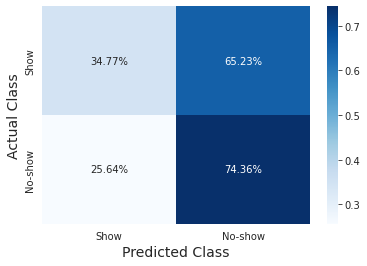

In [ ]:
#Deserialize model
model_file = open('/content/drive/MyDrive/BigData/DecisionTreeClassifier_no_wdays','rb')
model = pickle.load(model_file)
model_file.close()


# Evaluation
train_prediction = model.predict(X_train_no_wdays)
test_prediction = model.predict(X_test_no_wdays)

print("********** DECISION TREE **********")
print("RESULTS ON TRAINING SET:")
report_scores(y_train, train_prediction)
print("RESULTS ON TEST SET:")
report_scores(y_test, test_prediction)

conf_matrix = confusion_matrix(y_test, test_prediction, normalize='true')
sns.heatmap(conf_matrix, annot=True, fmt='.2%', cmap='Blues',xticklabels=['Show', 'No-show'], yticklabels=['Show', 'No-show'])
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()
print("\n\n\n\n")

As expected, both Precision and Recall scores are worse compared to the previous decision tree.

We draw the decision tree to inspect it visually.

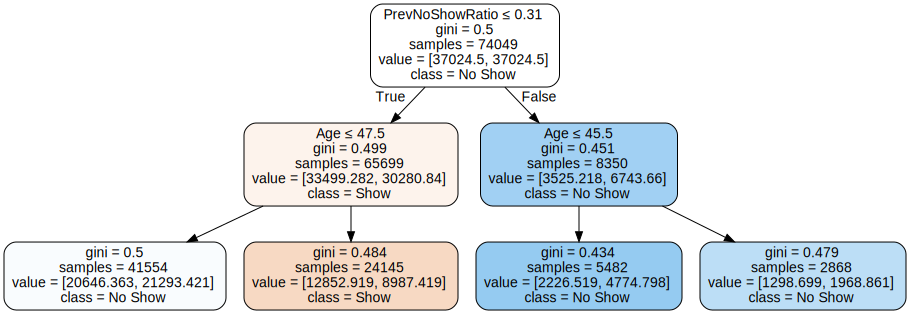

In [ ]:
dot_data = tree.export_graphviz(model, out_file=None, feature_names=X_train_no_wdays.columns, class_names=["Show", "No Show"], filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data, format="png") 
graph

Again, the decision tree is very simple. The features considered by the decision tree are only *PrevNoShowRatio* and *Age*, that were considered also by the previous decision tree. 

Since this decision tree does not give us more insights, we do not analyse it further. 

<a id='gaussian'></a>
# GaussianNB: interpretation and explanation

We try to interpret and to explain the GaussianNB model (the one trained on the rebalanced dataset) since this model achieves similar results to the Decision Tree (85\% Recall and 22\% Precision) and also this is not a tree-based model. By doing so, we hope to get more insights regarding the importance of the other variables and the relationships between them and the target class.

In [ ]:
gaussianNB_smote_file = open('/content/drive/MyDrive/BigData/GaussianNB_smote','rb')
gaussianNB = pickle.load(gaussianNB_smote_file)
gaussianNB_smote_file.close()

In order to save execution time, we build the kernel explainer with the first 5000 record of the training set.

In [ ]:
explainer_gaussian = shap.KernelExplainer(gaussianNB.predict_proba, X_train[:5000])

Using 5000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Again, to save time we compute the SHAP values for only the first 5000 records of the test set.

In [ ]:
# WARNING: LONG TIME EXECUTION!
shap_values_gaussian = explainer_gaussian.shap_values(X_test[:5000])
# Serialize shap_values_gaussian
shap_values_file = open('/content/drive/MyDrive/BigData/shap_values_gaussian_pickle', 'wb')
pickle.dump(shap_values_gaussian, shap_values_file)
shap_values_file.close()

In [ ]:
# Load shap_values_gaussian from file
shap_values_file = open('/content/drive/MyDrive/BigData/shap_values_gaussian_pickle','rb')
shap_values_gaussian = pickle.load(shap_values_file)
shap_values_file.close()

## Global Explanation

Now we visualize the variable importance plot and the predictive power of each variable.

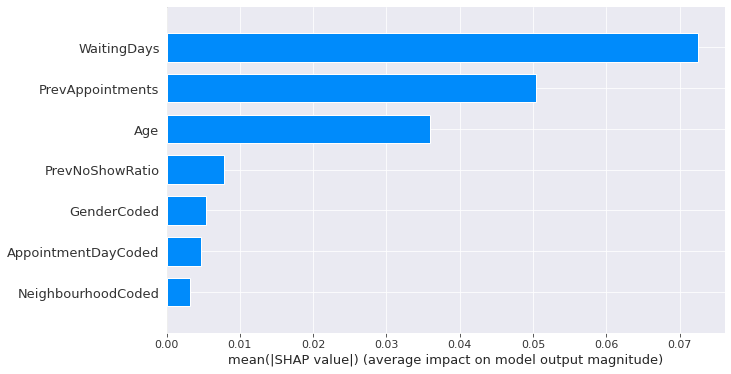

In [ ]:
shap.summary_plot(shap_values_gaussian[1], X_test[:5000], plot_type="bar", plot_size=(10, 6))

*WaitingDays*, *PrevAppointments* and *Age* are the most important features. The other features are less important. We note that the features *WaitingDays* and *Age* were considered also by the decision tree while *PrevAppointments* was not considered. Moreover, the decision tree was also considering *PrevNoShowRatio* but here *PrevAppointments* seems to be more important.

We now plot a more detailed version of the summary plot.

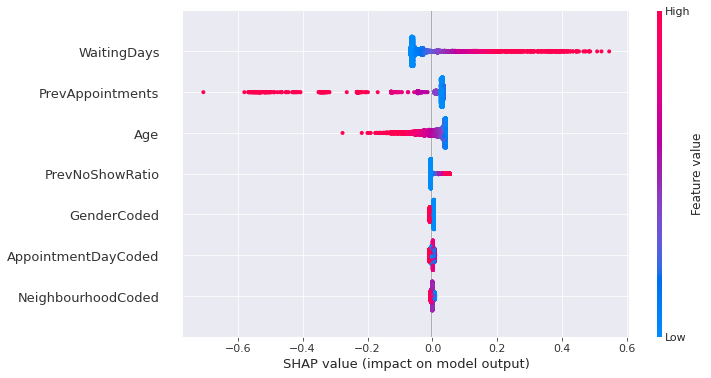

In [ ]:
shap.summary_plot(shap_values_gaussian[1], X_test[:5000], plot_size=(10, 6))

We can see that: 
*  As the value of *WaitingDays* and *PrevNoShowRation* increases, their positive impact on the No-Show class increases. However, low values for these attributes do not impact the No-Show class. 
*  As the value of *PrevAppointments* and *Age* increases, their negative impact on the No-Show class increases. However, high values for these attributes do not impact the No-Show class. 
*  The other features seem to have little impact on the No-Show class.

We plot the dependence plots for the most impactful features.

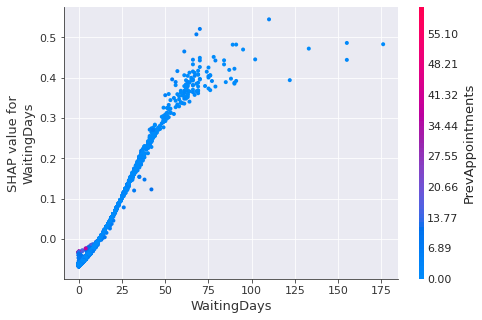

In [ ]:
shap.dependence_plot("WaitingDays", shap_values_gaussian[1], X_test[:5000])

The plot shows that there is an approximatly linear positive trend between *WaitingDays* and the target variable. The feature *WaitingDays* interacts most with *PrevAppointments* but we do not see any meaningful pattern in the plot.

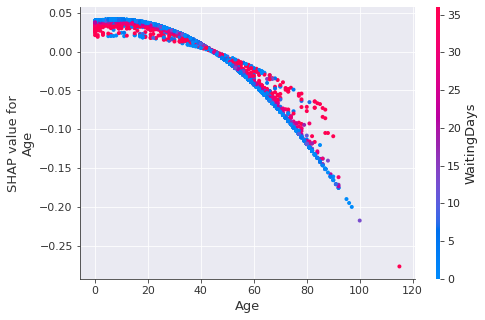

In [ ]:
shap.dependence_plot("Age", shap_values_gaussian[1], X_test[:5000])

The plot shows that there is a negative trend between *Age* and the target variable. The feature *Age* interacts most with *WaitingDays* but we do not see any meaningful pattern in the plot.

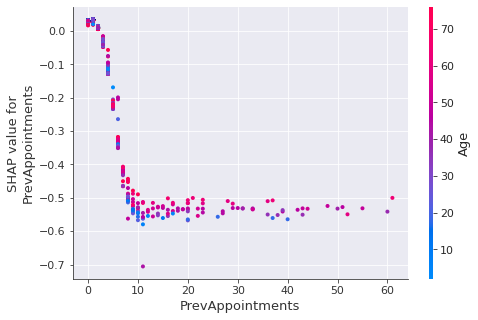

In [ ]:
shap.dependence_plot("PrevAppointments", shap_values_gaussian[1], X_test[:5000])

The plot shows that as the value of *PrevAppointments* increases, also it's negative impact increases, until it stabilizes around -0.5. The feature *PrevAppointments* interacts most with *Age* but we do not see any meaningful pattern in the plot.

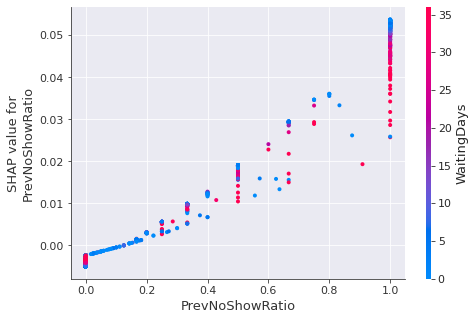

In [ ]:
shap.dependence_plot("PrevNoShowRatio", shap_values_gaussian[1], X_test[:5000])

The plot shows that there is an approximatly linear positive trend between *PrevNoShowRatio* and the target variable. The feature *PrevNoShowRatio* interacts most with *WaitingDays* but we do not see any meaningful pattern in the plot.

In conclusion, we have observed that the features *WaitingDays* and *PrevNoShowRatio* have a positive impact on the No-Show class, while the features *PrevAppointments* and *Age* are the ones with the most negative impact on the No-Show class. 
Some possible interpretations could be: 

*  Patients that book appointments long in advance are more likely to not show up, maybe because they forget about it or they can not go anymore due to some unforeseen event.

*  Patient with a history of no-shows are more likely to not show up to the appointments.

*  Older patients are less likely to skip appointments with respect to younger patients. This could be due to more severe health conditions related to the patient's age. Unfortunatly, we do not have any information about the the type of medical examination.

*  Patients that have booked several appointments during the observation period tend to show up to the next one. Perhaps this patients are treating a particular disease, or have some kind of health issue that requires them to do frequent medical visits.

## Local Explanation

In this section we look at the model predicitons for five records taken from the test set in order to understand how the different attributes affect the model's behaviour.

Here we show the base value for the No-Show class.

In [ ]:
print("BASE VALUE of the NO SHOW class: ", round(explainer_gaussian.expected_value[1], 2))

BASE VALUE of the NO SHOW class:  0.57


For each record, we get the actual class, the prediction from the decision tree model and the prediction from the GaussianNB model. For the GaussianNB model's predictions, we show the decision plot and the force plot. For the decision tree's predictions, we do not need to do this since the rule used for the classification is a simple if statement.

In [ ]:
row_indexes = [24, 137, 831, 48, 19]

class_name = {
  0 : "SHOW",
  1 : "NO SHOW",
}

gaussian_predictions = gaussianNB.predict(X_test.iloc[row_indexes])
decision_tree_predictions = decision_tree.predict(X_test.iloc[row_indexes])

The first record has the following values for the attributes:

In [ ]:
index = row_indexes[0]
X_test.iloc[[index]]

,Age,WaitingDays,PrevAppointments,PrevNoShowRatio,GenderCoded,NeighbourhoodCoded,AppointmentDayCoded
24,60,29,0,0.0,0.0,67.0,5.0


In [ ]:
i = y_test.iloc[index]['No_show']
print("ACTUAL CLASS:", class_name[i])
print("Decision tree prediction:", class_name[decision_tree_predictions[0]])
print("GaussianNB prediction:", class_name[gaussian_predictions[0]])


ACTUAL CLASS: SHOW
Decision tree prediction: NO SHOW
GaussianNB prediction: NO SHOW


The actual class of the record is Show, but both the decision tree and gaussianNB model classify this record as No-Show. 

The decision tree missclassifies the record since *WaitingDays* has value 29 that is greater than 0.

Now we draw the force plot and the decision plot related to the gaussianNB model's classification.

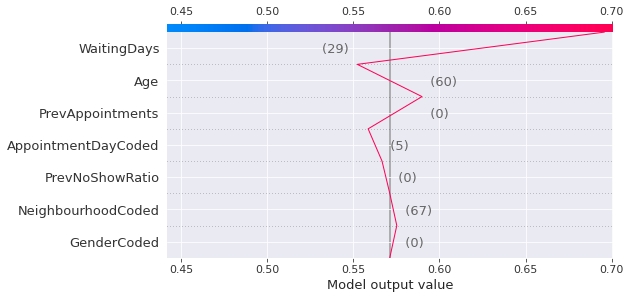

In [ ]:
shap.decision_plot(explainer_gaussian.expected_value[1], shap_values_gaussian[1][index], X_test.iloc[[index]])
print("\n")
shap.initjs()
shap.force_plot(explainer_gaussian.expected_value[1], shap_values_gaussian[1][index], X_test.iloc[[index]])

The attributes that mostly lead to the missclassification are *WaitingDays* and *PrevAppointments*. In particular, we observe: 
* The very high *WaitingDays* value completely misleads the model.
* Another reason why the model missclassifies the record is that the patient has no prior appointments recorded in the dataset. As previously observed, high *PrevAppointments* values negatively affect the No-Show classification.
* The high value of the attribute *Age* correctly affects the prediction of the record but the model does not give it enough importance.

The second record has the following values for the attributes:

In [ ]:
index = row_indexes[1]
X_test.iloc[[index]]

,Age,WaitingDays,PrevAppointments,PrevNoShowRatio,GenderCoded,NeighbourhoodCoded,AppointmentDayCoded
137,87,7,0,0.0,0.0,43.0,5.0


In [ ]:
i = y_test.iloc[index]['No_show']
print("ACTUAL CLASS:", class_name[i])
print("Decision tree prediction:", class_name[decision_tree_predictions[1]])
print("GaussianNB prediction:", class_name[gaussian_predictions[1]])

ACTUAL CLASS: SHOW
Decision tree prediction: NO SHOW
GaussianNB prediction: SHOW


The actual class of the record is Show, but the decision tree classifies is as No-show. Instead, the gaussianNB model correctly classify the record as Show.

The decision tree missclassifies the record since WaitingDays has value 7 that is greater than 0.

Now we draw the force plot and the decision plot related to the gaussianNB model's classification.

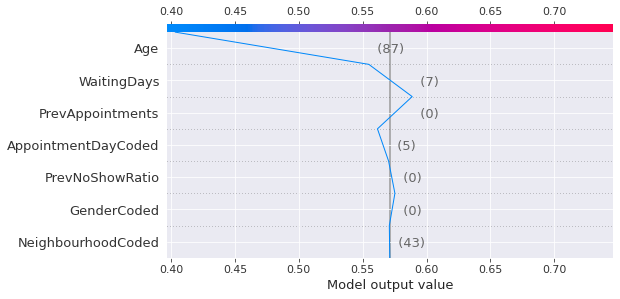

In [ ]:
shap.decision_plot(explainer_gaussian.expected_value[1], shap_values_gaussian[1][index], X_test.iloc[[index]])
print("\n")
shap.initjs()
shap.force_plot(explainer_gaussian.expected_value[1], shap_values_gaussian[1][index], X_test.iloc[[index]])

We observe that: 
*  The attribute that most influences the classification is *Age*. It has has a very high value and this is what in the end leads the model to correctly classify the record.

* This time the attribute *WaitingDays* leads the model to the correct prediction, since it has quite a low value. We note that this value, although quite low, still leads the decision tree to misclassify the record.

* The attribute that mostly misleads the model is *PrevAppointments* since it has a value of 0. 

The third record has the following values for the attributes:

In [ ]:
index = row_indexes[2]
X_test.iloc[[index]]

,Age,WaitingDays,PrevAppointments,PrevNoShowRatio,GenderCoded,NeighbourhoodCoded,AppointmentDayCoded
831,2,2,1,0.0,1.0,67.0,3.0


In [ ]:
i = y_test.iloc[index]['No_show']
print("ACTUAL CLASS:", class_name[i])
print("Decision tree prediction:", class_name[decision_tree_predictions[2]])
print("GaussianNB prediction:", class_name[gaussian_predictions[2]])

ACTUAL CLASS: SHOW
Decision tree prediction: NO SHOW
GaussianNB prediction: NO SHOW


The actual class of the record is Show, but both the decision tree and gaussianNB model classify this record as No-Show.

The decision tree missclassifies the record since *WaitingDays* has value 2 that is greater than 0.

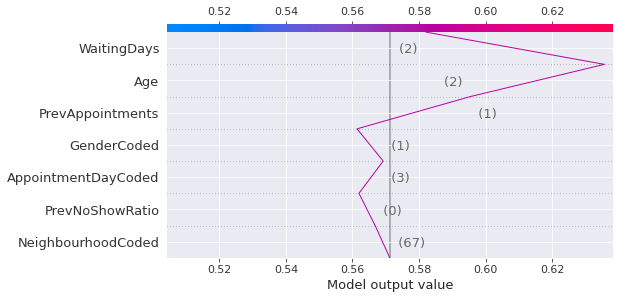

In [ ]:
shap.decision_plot(explainer_gaussian.expected_value[1], shap_values_gaussian[1][index], X_test.iloc[[index]])
print("\n")
shap.initjs()
shap.force_plot(explainer_gaussian.expected_value[1], shap_values_gaussian[1][index], X_test.iloc[[index]])

We observe that: 
* The probability assigned to the No-Show class is only 0.58 so the model finds it quite difficult to classify this record.  
* The two attributes that mostly mislead the model are *Age* and *PrevAppointments*, both having very low values. 

* Even if the value of the attribute *WaitingDays* is very low (2) it is not enough to make the model predict the correct class.

The fourth record has the following attributes:

In [ ]:
index = row_indexes[3]
X_test.iloc[[index]]

,Age,WaitingDays,PrevAppointments,PrevNoShowRatio,GenderCoded,NeighbourhoodCoded,AppointmentDayCoded
48,36,51,0,0.0,0.0,42.0,0.0


In [ ]:
i = y_test.iloc[index]['No_show']
print("ACTUAL CLASS:", class_name[i])
print("Decision tree prediction:", class_name[decision_tree_predictions[3]])
print("GaussianNB prediction:", class_name[gaussian_predictions[3]])

ACTUAL CLASS: NO SHOW
Decision tree prediction: NO SHOW
GaussianNB prediction: NO SHOW


Both the decision tree and gaussianNB model classify correctly this record as No-Show.

The decision tree classifies the record as No-Show since WaitingDays has value 51 that is greater than 0.

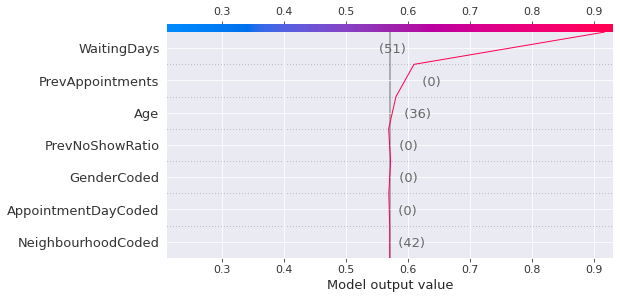

In [ ]:
shap.decision_plot(explainer_gaussian.expected_value[1], shap_values_gaussian[1][index], X_test.iloc[[index]])
print("\n")
shap.initjs()
shap.force_plot(explainer_gaussian.expected_value[1], shap_values_gaussian[1][index], X_test.iloc[[index]])

We observe that:
*  The attribute that mostly contributes to the prediction is *WaitingDays* that has a very high value.
*  Also, the facts that the patient has no previous appointments and that he is quite young (36 years old) contribute to get the right prediction.


The fifth record has the following attributes:

In [ ]:
index = row_indexes[4]
X_test.iloc[[index]]

,Age,WaitingDays,PrevAppointments,PrevNoShowRatio,GenderCoded,NeighbourhoodCoded,AppointmentDayCoded
19,17,1,0,0.0,0.0,33.0,5.0


In [ ]:
i = y_test.iloc[index]['No_show']
print("ACTUAL CLASS:", class_name[i])
print("Decision tree prediction:", class_name[decision_tree_predictions[4]])
print("GaussianNB prediction:", class_name[gaussian_predictions[4]])

ACTUAL CLASS: NO SHOW
Decision tree prediction: NO SHOW
GaussianNB prediction: NO SHOW


Both the decision tree and gaussianNB model classify correctly this record as No-Show.

The decision tree classifies the record as No-Show since *WaitingDays* has value 1 that is greater than 0.

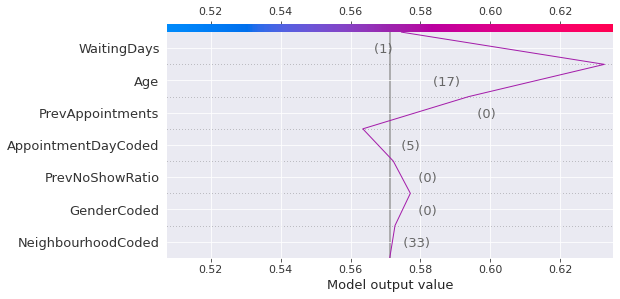

In [ ]:
shap.decision_plot(explainer_gaussian.expected_value[1], shap_values_gaussian[1][index], X_test.iloc[[index]])
print("\n")
shap.initjs()
shap.force_plot(explainer_gaussian.expected_value[1], shap_values_gaussian[1][index], X_test.iloc[[index]])

We observe that:
*  The value of the *WaitingDays* attribute is very low and this would lead the model to missclassify the record. This is the opposite of what happens with the decision tree classifier: since the value is greater than 0 the model makes the correct prediction.
*  Nevertheless, since the patient is young (17 years old) and he has no prior appointments in the dataset, the gaussianNB model is able to assign the record the correct class.

<a id='conclusions'></a>
# Conclusions

We took the best performing model from the previous analysis, that was the decision tree, we visualized the tree and realized that it was a very trivial model. For this reason we decided to explain with the SHAP library the gaussianNB model. Although this model is less performing, we obtained more meaningful insights and explanations.

In conclusion, we observe that for all the tested models it is quite difficult to classify records. This is reflected by the low precision of the models and by the simple and intuitive explanations that we obtained (i.e. longer waiting days lead to patients not showing up, younger patients tends to do more No-Shows, ...).  Indeed, the fact that a patient will show up or not to an appointment could be influenced by a lot of external factors that can not be captured in dataset.

# Save the Notebook

In [3]:
# Execute this to save new versions of the notebook
jovian.commit(project="bda-project-part-3")

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/m-cere/bda-project-part-3


'https://jovian.ai/m-cere/bda-project-part-3'